# Playground01 goals
1. This playground is dedicated for accessing and understanding the dataset filesystem.
The plan is figure out:
    1. how many sampling frequencies we have
    1. what are the shared eeg channels among all recordings
    1. what the available durations (mean, std, max and min)
2. preprocessing the data by picking out the desired channels and resampling

In [3]:
%pip install mne

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install seaborn

25989.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [1]:
import tqdm

In [41]:
%pip install joblib h5py tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 2.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import mne
print(f"mne version: {mne.__version__}")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

mne version: 1.6.1


# Variables

In [14]:
data_dir = '/Users/belial/Public/OneDrive - elte.hu/ELTE/Research_Projects/P2-Anomaly_detection/TUH_EEG_Corpus_v2.0.1/'


# Accessing edf files
## locating edf files inside the directory path
we can assign which montage we would like '_tcp_ar'(defualt) or '_tcp_le'
we can also indicate if we want epilipsy data or no_epilipsy (defults to with epilipsy)

In [15]:
def find_edf_files(root_dir: str, montage: str = '_tcp_ar', epilipsy: bool = True) -> tuple:
    path2edf = []
    edf_files_dict = {}
    empty_dirs = []
    if epilipsy:
        identifier = '00_epilepsy'
    else:
        identifier = '01_no_epilepsy'
    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Check if the directory is empty
        if not dirnames and not filenames:
            print(f"Directory {dirpath} is empty.")
            continue
        # Check if the directory contains EDF files
        if not any(file.lower().endswith('.edf') for file in filenames):
            print(f"No EDF files found in {dirpath}.")
            empty_dirs.append(dirpath)
            continue
    
        for file in filenames:
            if file.lower().endswith('.edf'):
                if dirpath.find(montage) != -1 and dirpath.find(identifier) != -1:
                    path2edf.append(os.path.join(dirpath, file)) 
                    edf_files_dict[file] = os.path.join(dirpath, file)

    return path2edf, edf_files_dict, empty_dirs



In [20]:
print("Finding EDF files...")
edf_files, edf_files_dict, _ = find_edf_files(data_dir, montage='_ar',  epilipsy=False)
print(f"Found {len(edf_files)} EDF files.")
#print(f"Found {len(edf_files[2])} empty.")
#print(edf_files[1].keys())

Finding EDF files...
No EDF files found in /Users/belial/Public/OneDrive - elte.hu/ELTE/Research_Projects/P2-Anomaly_detection/TUH_EEG_Corpus_v2.0.1/.
No EDF files found in /Users/belial/Public/OneDrive - elte.hu/ELTE/Research_Projects/P2-Anomaly_detection/TUH_EEG_Corpus_v2.0.1/00_epilepsy.
No EDF files found in /Users/belial/Public/OneDrive - elte.hu/ELTE/Research_Projects/P2-Anomaly_detection/TUH_EEG_Corpus_v2.0.1/00_epilepsy/aaaaaoui.
No EDF files found in /Users/belial/Public/OneDrive - elte.hu/ELTE/Research_Projects/P2-Anomaly_detection/TUH_EEG_Corpus_v2.0.1/00_epilepsy/aaaaaoui/s002_2013.
No EDF files found in /Users/belial/Public/OneDrive - elte.hu/ELTE/Research_Projects/P2-Anomaly_detection/TUH_EEG_Corpus_v2.0.1/00_epilepsy/aaaaaoui/s001_2013.
No EDF files found in /Users/belial/Public/OneDrive - elte.hu/ELTE/Research_Projects/P2-Anomaly_detection/TUH_EEG_Corpus_v2.0.1/00_epilepsy/aaaaakvr.
No EDF files found in /Users/belial/Public/OneDrive - elte.hu/ELTE/Research_Projects/P2-

## Extracting Metadata

In [7]:
def read_edf_metadata(edf_path):
    try:
        raw = mne.io.read_raw_edf(edf_path, preload=False, verbose='ERROR')
        info = raw.info
        metadata = {
            'file_path': edf_path,
            'n_channels': info['nchan'],
            'sample_rate': info['sfreq'],
            'duration_sec': raw.n_times / info['sfreq'],
            'n_samples': raw.n_times,
            'channel_names': info['ch_names'],
            'channel_positions': info['chs']
            #'events': raw.annotations.events,
        }
        return metadata
    except Exception as e:
        print(f"Failed to read {edf_path}: {e}")
        return None

In [9]:
def get_metadata_from_files(edf_files: list, save2csv: bool = False, output_file: str = './txt_files/metadata.txt') -> list:
    metadata_list = []
    for edf_file in edf_files:
        metadata = read_edf_metadata(edf_file)
        if metadata:
            metadata_list.append(metadata)
    if save2csv:
        df = pd.DataFrame(metadata_list)
        df.to_csv(output_file, index=False)
        print(f"Metadata saved to {output_file}")
    return metadata_list

In [12]:
metadata_list = get_metadata_from_files(edf_files, save2csv=True, output_file='./txt_files/metadata.csv')

Metadata saved to ./txt_files/metadata.csv


# metadata stats
metadata = {
    'file_path': edf_path,
    'n_channels': info['nchan'],
    'sample_rate': info['sfreq'],
    'duration_sec': raw.n_times / info['sfreq'],
    'n_samples': raw.n_times,
    'channel_names': info['ch_names'],
    'meas_date': info['meas_date']
}
1. mean, standard deviation, max and min of 'duration_sec' for all files.
2. mean, max and min of 'n_channels' for all files.
3. mean, standard deviation, max and min of 'n_samples' for all files.
4. all the different values available for 'sample_rate' for all files without repetition.
5. all the shared channels found in 'channel_names' across all files.

In [13]:
def compute_metadata_statistics(metadata_list):
    stats = {}
    rounding = 2
    # 1. Statistics for 'duration_sec'
    durations = [m['duration_sec'] for m in metadata_list]
    stats['duration_sec'] = {
        'mean': np.mean(durations).round(rounding) if durations else None,
        'std': np.std(durations).round(rounding) if durations else None,
        'max': np.max(durations) if durations else None,
        'min': np.min(durations) if durations else None
    }
    
    # 2. Statistics for 'n_channels'
    n_channels = [m['n_channels'] for m in metadata_list]
    stats['n_channels'] = {
        'mean': np.mean(n_channels).round(rounding) if n_channels else None,
        'max': np.max(n_channels) if n_channels else None,
        'min': np.min(n_channels) if n_channels else None
    }
    
    # 3. Statistics for 'n_samples'
    n_samples = [m['n_samples'] for m in metadata_list]
    stats['n_samples'] = {
        'mean': np.mean(n_samples).round(rounding) if n_samples else None,
        'std': np.std(n_samples).round(rounding) if n_samples else None,
        'max': np.max(n_samples) if n_samples else None,
        'min': np.min(n_samples) if n_samples else None
    }
    
    # 4. Unique 'sample_rate' values
    sample_rates = {m['sample_rate'] for m in metadata_list}
    stats['sample_rate'] = sorted(sample_rates)  # Sorted for readability
    
    # 5. Shared channels across all files
    if not metadata_list:
        stats['shared_channels'] = []
    else:
        common_channels = set(metadata_list[0]['channel_names'])
        for m in metadata_list[1:]:
            common_channels.intersection_update(m['channel_names'])
            if not common_channels:
                break  # Early exit if no common channels
        stats['shared_channels'] = sorted(common_channels)  # Sorted for readability
    
    return stats

In [14]:
metadata_stat = compute_metadata_statistics(metadata_list)
print(f"Metadata statistics:{metadata_stat}")

Metadata statistics:{'duration_sec': {'mean': 1085.28, 'std': 3448.01, 'max': 63373.0, 'min': 1.0}, 'n_channels': {'mean': 31.97, 'max': 36, 'min': 17}, 'n_samples': {'mean': 311293.86, 'std': 922147.63, 'max': 16223488, 'min': 256}, 'sample_rate': [250.0, 256.0, 400.0, 512.0, 1000.0], 'shared_channels': ['EEG C3-REF', 'EEG C4-REF', 'EEG CZ-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG FP1-REF', 'EEG FP2-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF']}


In [15]:
def create_stats_dataframe(stats_dict):
    # Initialize a list to hold rows for the DataFrame
    rows = []
    
    # Process numerical metrics with mean/std/min/max
    numerical_metrics = ['duration_sec', 'n_channels', 'n_samples']
    for metric in numerical_metrics:
        row = {
            'metric': metric,
            'mean': stats_dict[metric].get('mean'),
            'std': stats_dict[metric].get('std'),
            'max': stats_dict[metric].get('max'),
            'min': stats_dict[metric].get('min'),
            'unique_values': None,
            'shared_channels': None
        }
        rows.append(row)
    
    # Process sample_rate (unique values)
    rows.append({
        'metric': 'sample_rate',
        'mean': None,
        'std': None,
        'max': None,
        'min': None,
        'unique_values': stats_dict['sample_rate'],
        'shared_channels': None
    })
    
    # Process shared_channels (common across files)
    rows.append({
        'metric': 'shared_channels',
        'mean': None,
        'std': None,
        'max': None,
        'min': None,
        'unique_values': None,
        'shared_channels': stats_dict['shared_channels']
    })
    
    # Create DataFrame
    df_stats = pd.DataFrame(rows)
    return df_stats

In [16]:
# Compute the statistics using your metadata list
stats = compute_metadata_statistics(metadata_list)

# Create the organized DataFrame
df_stats = create_stats_dataframe(stats)
unique_sfreqs = df_stats.at[3, 'unique_values']
shared_channels = df_stats.at[4, 'shared_channels']
print(f"Unique sample rates: {unique_sfreqs}")
print(f"Shared channels: {shared_channels}")
print(df_stats[['metric', 'mean', 'std', 'max', 'min']])


Unique sample rates: [250.0, 256.0, 400.0, 512.0, 1000.0]
Shared channels: ['EEG C3-REF', 'EEG C4-REF', 'EEG CZ-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG FP1-REF', 'EEG FP2-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF']
            metric       mean        std         max    min
0     duration_sec    1085.28    3448.01     63373.0    1.0
1       n_channels      31.97        NaN        36.0   17.0
2        n_samples  311293.86  922147.63  16223488.0  256.0
3      sample_rate        NaN        NaN         NaN    NaN
4  shared_channels        NaN        NaN         NaN    NaN


In [21]:
len(shared_channels)

17

## Visualizing stats
### 1. Duration Statistics (Boxplot + Histogram)

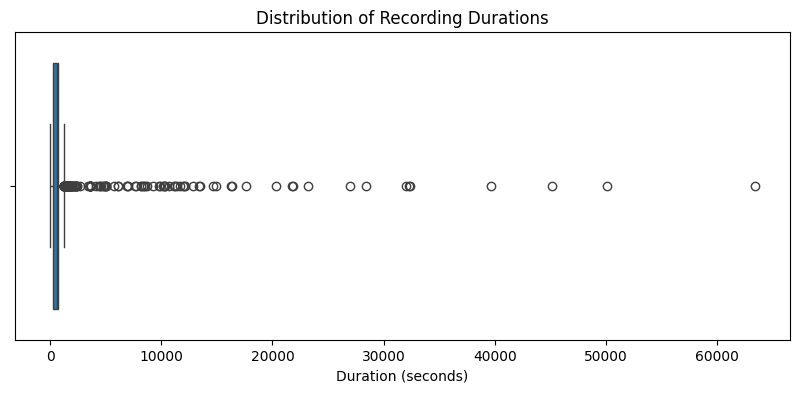

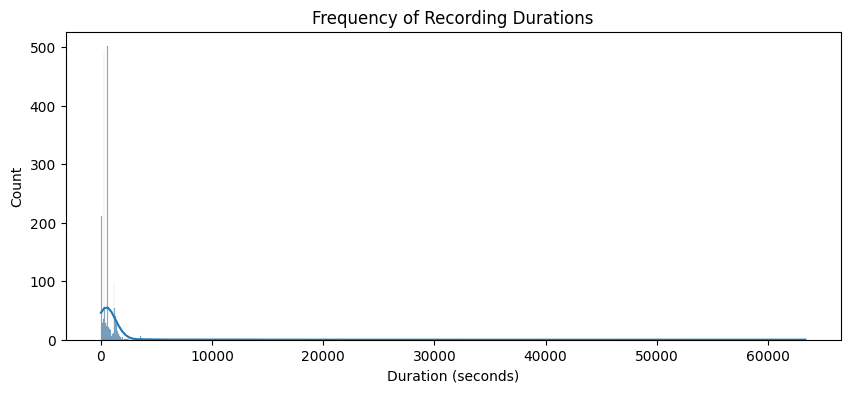

In [23]:
durations = [m['duration_sec'] for m in metadata_list]

# Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=durations)
plt.title("Distribution of Recording Durations")
plt.xlabel("Duration (seconds)")
plt.show()

# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(durations, kde=True)
plt.title("Frequency of Recording Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

<Axes: >

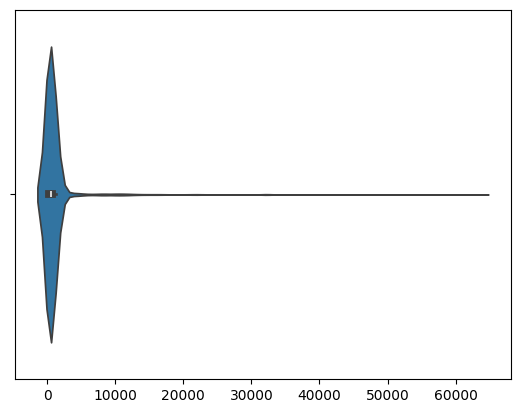

In [26]:
sns.violinplot(x=durations)

### 2. Channel Count Statistics (Bar Plot)

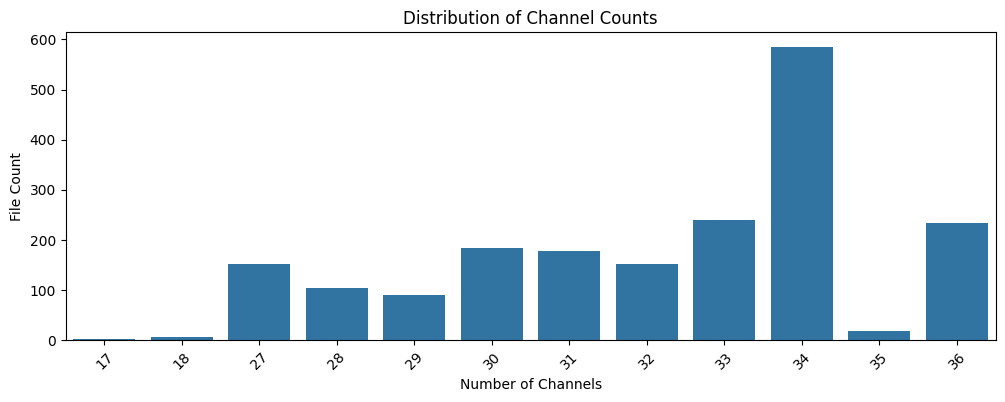

In [24]:
n_channels = [m['n_channels'] for m in metadata_list]

plt.figure(figsize=(12, 4))
sns.countplot(x=n_channels)
plt.title("Distribution of Channel Counts")
plt.xlabel("Number of Channels")
plt.ylabel("File Count")
plt.xticks(rotation=45)
plt.show()

### 3. Sample Statistics (Boxplot)

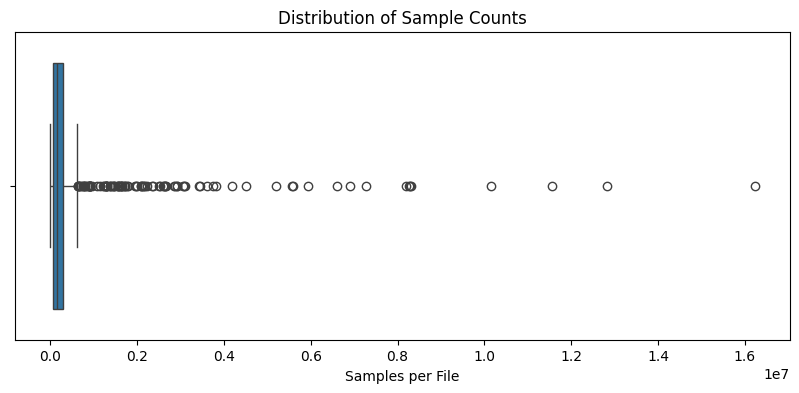

In [27]:
n_samples = [m['n_samples'] for m in metadata_list]

plt.figure(figsize=(10, 4))
sns.boxplot(x=n_samples)
plt.title("Distribution of Sample Counts")
plt.xlabel("Samples per File")
plt.show()

### 4. Unique Sample Rates (Bar Plot)

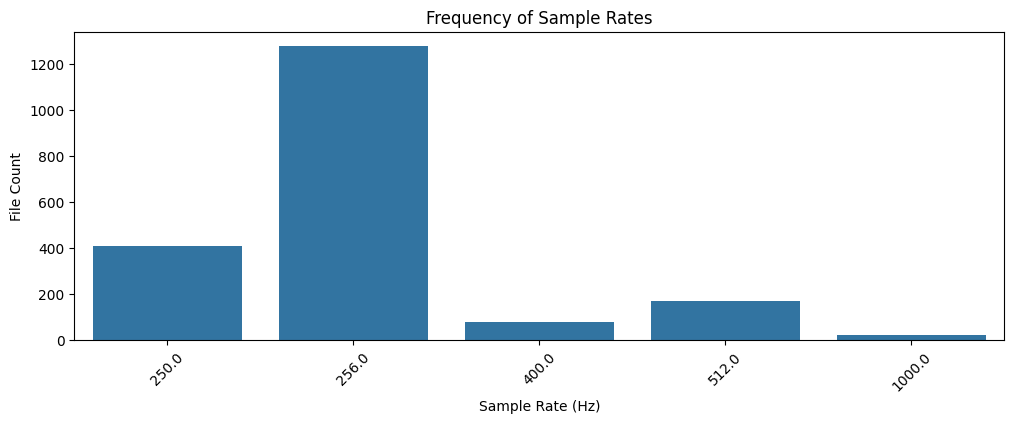

In [28]:
from collections import Counter

sample_rates = [m['sample_rate'] for m in metadata_list]
rate_counts = Counter(sample_rates)

plt.figure(figsize=(12, 4))
sns.barplot(x=list(rate_counts.keys()), y=list(rate_counts.values()))
plt.title("Frequency of Sample Rates")
plt.xlabel("Sample Rate (Hz)")
plt.ylabel("File Count")
plt.xticks(rotation=45)
plt.show()

### 5. Shared Channels (Horizontal Bar Plot)

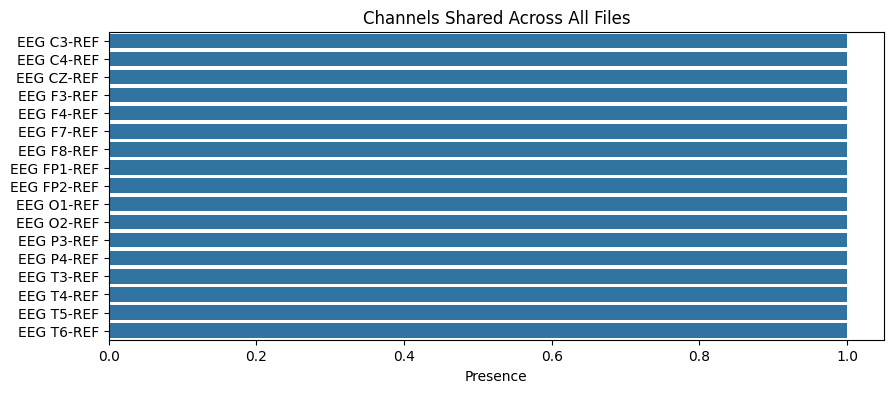

In [29]:
shared_channels = stats['shared_channels']  # From earlier computation

if shared_channels:
    plt.figure(figsize=(10, 4))
    sns.barplot(x=[1]*len(shared_channels), y=shared_channels, orient='h')
    plt.title("Channels Shared Across All Files")
    plt.xlabel("Presence")
    plt.yticks(rotation=0)
    plt.show()
else:
    print("No shared channels across all files.")

In [ ]:
    from collections import Counter

def compute_channel_stats(metadata_list):
    # Flatten all channel names across files
    all_channels = [channel for m in metadata_list for channel in m['channel_names']]
    channel_freq = Counter(all_channels)
    
    # Identify shared channels (common across all files)
    if not metadata_list:
        shared_channels = set()
    else:
        shared_channels = set(metadata_list[0]['channel_names'])
        for m in metadata_list[1:]:
            shared_channels.intersection_update(m['channel_names'])
    
    # Create DataFrame with frequency and shared status
    df_channels = pd.DataFrame({
        'channel': list(channel_freq.keys()),
        'frequency': list(channel_freq.values()),
        'is_shared': [ch in shared_channels for ch in channel_freq.keys()]
    })
    
    # Sort by frequency (descending)
    df_channels = df_channels.sort_values(by='frequency', ascending=False)
    
    return df_channels

In [31]:
def plot_channel_frequencies(df_channels):
    plt.figure(figsize=(10, 12))
    palette = {True: 'green', False: 'gray'}  # Highlight shared channels in green
    
    sns.barplot(
        x='frequency',
        y='channel',
        data=df_channels,
        hue='is_shared',
        palette=palette,
        dodge=False  # Avoid splitting bars for True/False
    )
    
    plt.title('Channel Frequencies (Shared Channels Highlighted)')
    plt.xlabel('Number of Files Containing Channel')
    plt.ylabel('Channel Name')
    plt.legend(title='Shared Across All Files', labels=['No', 'Yes'])
    plt.show()

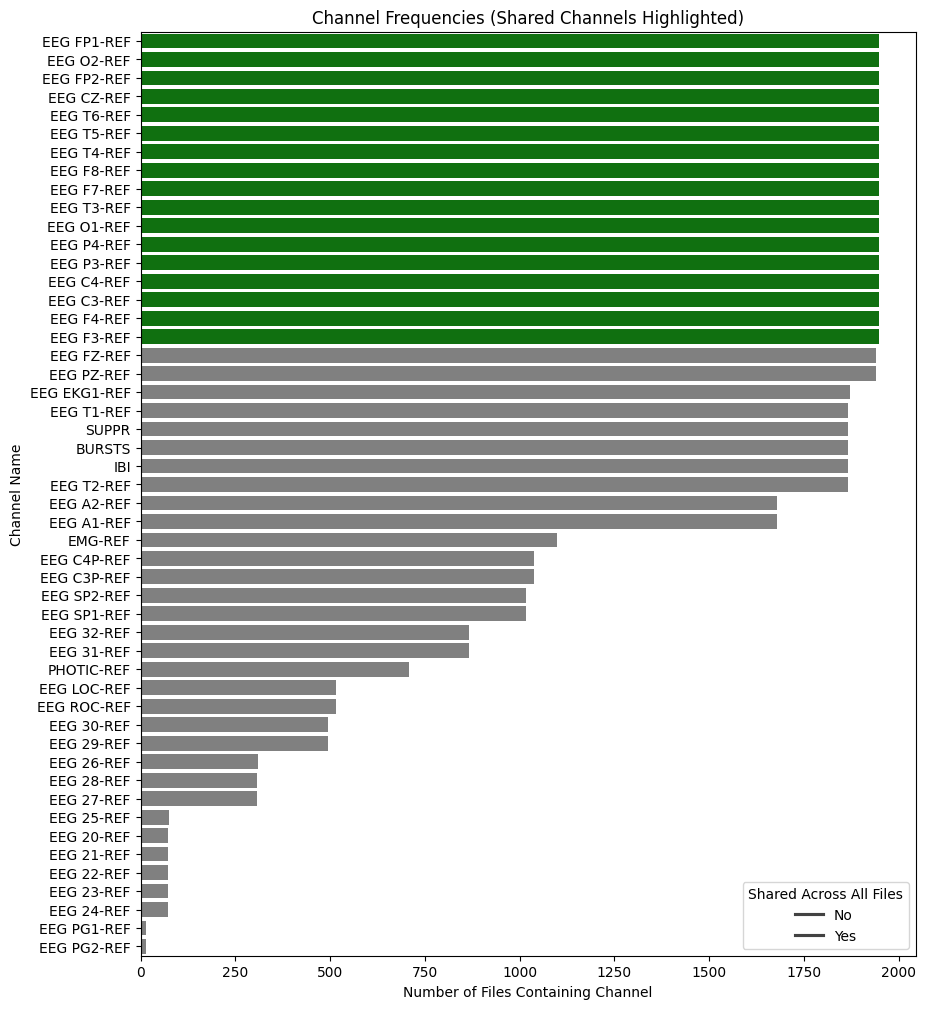

In [32]:
# Compute channel frequencies and shared status
df_channels = compute_channel_stats(metadata_list)

# Plot
plot_channel_frequencies(df_channels)

# Preprocessing

In [ ]:
from typing import Optional, List

def preprocess_eeg(
    file_path: str,
    selected_channels: Optional[List[str]] = None,
    sfreq: int = 256,
    l_freq: float = 1.0,
    h_freq: float = 40.0,
    normalize: bool = True,
    verbose: bool = False
) -> Optional[np.ndarray]:
    """
    Args:
        file_path: Path to .edf EEG file.
        selected_channels: List of channel names to pick (optional).
        sfreq: Target sampling frequency after resampling.
        l_freq: Low cutoff for bandpass filter.
        h_freq: High cutoff for bandpass filter.
        normalize: If True, apply Z-score normalization per channel.
        verbose: Log preprocessing steps.

    Returns:
        Preprocessed data as numpy array (channels × samples), or None if processing fails.
    """
    try:
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=verbose)
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

    # Check if selected_channels exist in the file
    if selected_channels:
        available_chs = raw.ch_names
        missing_chs = [ch for ch in selected_channels if ch not in available_chs]
        if missing_chs:
            print(f"Warning: Missing channels {missing_chs} in {file_path}. Skipping.")
            return None
        raw.pick_channels(selected_channels)

    # Resample
    if raw.info['sfreq'] != sfreq:
        raw.resample(sfreq, verbose=verbose)

    # Bandpass filter
    raw.filter(l_freq=l_freq, h_freq=h_freq, verbose=verbose)


    # Normalize
    data = raw.get_data()
    if normalize:
        data = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True) + 1e-8)

    # Free memory
    del raw
    return data

In [19]:
from joblib import Parallel, delayed
from tqdm import tqdm  # For progress bars

def preprocess_bulk(
    file_paths: List[str],
    selected_channels: Optional[List[str]] = None,
    n_jobs: int = -1  # Use all CPU cores
) -> List[Optional[np.ndarray]]:
    return Parallel(n_jobs=n_jobs)(
        delayed(preprocess_eeg)(fp, selected_channels)
        for fp in tqdm(file_paths, desc="Processing files")
    )

In [21]:
import h5py
preprocessed_data = preprocess_bulk(edf_files, selected_channels=shared_channels.append(['EEG FZ-REF','EEG PZ-REF']), n_jobs=4)
valid_data = [d for d in preprocessed_data if d is not None]
with h5py.File('preprocessed_data.h5', 'w') as hf:
    for i, (fp, data) in enumerate(zip(edf_files, valid_data)):
        if data is not None:
            hf.create_dataset(f'file_{i}', data=data, compression='gzip')

Processing files:   1%|          | 12/1679 [00:39<1:41:04,  3.64s/it]/Users/belial/.pyenv/versions/3.8.20/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing files:   5%|▌         | 84/1679 [03:11<1:08:26,  2.57s/it]/var/folders/gn/g0szlcgn2sq2ycrwdq8bmf5w0000gn/T/ipykernel_6646/2722106296.py:41: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
/var/folders/gn/g0szlcgn2sq2ycrwdq8bmf5w0000gn/T/ipykernel_6646/2722106296.py:41: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
/var/folders/gn/g0szlcgn2sq2ycrwdq8bmf5w0000gn/T/ipykernel_6646/2722106296.py:41: RuntimeWarning: filter_length (845) is longer than the signal (25

: 

# END

## 1. Inspect HDF5 Structure
First, understand how your data is organized in the HDF5 file. For example:

Groups: subject_1, subject_2, ...

Datasets: raw_data, metadata, events.##

In [ ]:
with h5py.File('preprocessed_data.h5', 'r') as hf:
    # List all groups/datasets
    print("HDF5 structure:")
    def print_structure(name, obj):
        print(f"{name} ({'Group' if isinstance(obj, h5py.Group) else 'Dataset'})")
    hf.visititems(print_structure)

HDF5 structure:
file_0 (Dataset)
file_1 (Dataset)
file_10 (Dataset)
file_100 (Dataset)
file_101 (Dataset)
file_102 (Dataset)
file_103 (Dataset)
file_104 (Dataset)
file_105 (Dataset)
file_106 (Dataset)
file_107 (Dataset)
file_108 (Dataset)
file_109 (Dataset)
file_11 (Dataset)
file_110 (Dataset)
file_111 (Dataset)
file_112 (Dataset)
file_113 (Dataset)
file_114 (Dataset)
file_115 (Dataset)
file_116 (Dataset)
file_117 (Dataset)
file_118 (Dataset)
file_119 (Dataset)
file_12 (Dataset)
file_120 (Dataset)
file_121 (Dataset)
file_122 (Dataset)
file_123 (Dataset)
file_124 (Dataset)
file_125 (Dataset)
file_126 (Dataset)
file_127 (Dataset)
file_128 (Dataset)
file_129 (Dataset)
file_13 (Dataset)
file_130 (Dataset)
file_131 (Dataset)
file_132 (Dataset)
file_133 (Dataset)
file_134 (Dataset)
file_135 (Dataset)
file_136 (Dataset)
file_137 (Dataset)
file_138 (Dataset)
file_139 (Dataset)
file_14 (Dataset)
file_140 (Dataset)
file_141 (Dataset)
file_142 (Dataset)
file_143 (Dataset)
file_144 (Dataset)
file_

In [ ]:
type(valid_data)
#np.save('eeg_data.npy', preprocessed_data[:][:]) 

list

In [ ]:
def segment_eeg(data, sfreq=256, window_sec=2, overlap=0.5):
    """
    Segment preprocessed EEG into overlapping windows.

    Args:
        data: np.array of shape (channels, samples)
        sfreq: sampling frequency
        window_sec: window size in seconds
        overlap: fraction of overlap between windows

    Returns:
        segments: np.array of shape (num_windows, channels, window_size)
    """
    n_channels, n_samples = data.shape
    window_size = int(window_sec * sfreq)
    step_size = int(window_size * (1 - overlap))

    segments = []
    for start_idx in range(0, n_samples - window_size + 1, step_size):
        end_idx = start_idx + window_size
        window = data[:, start_idx:end_idx]
        segments.append(window)

    segments = np.stack(segments, axis=0)
    return segments

In [ ]:
seg = segment_eeg(preprocessed_data[0], sfreq=256, window_sec=1, overlap=0.1)
print(f"Segmented data shape: {seg.shape}")

Segmented data shape: (1539, 21, 256)
